# Tiles generation

## Importing

In [20]:
import json
from google_drive_downloader import GoogleDriveDownloader as gdd
import shutil, os
from ops import load_opt, load_sar, generate_save_patches, min_max_scaler
import numpy as np
import logging
from PIL import Image
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pickle

## Setting parameters

In [4]:
#load the params-patches.json options
with open(os.path.join('v1', 'params-patches.json')) as param_file:
    params_patches = json.load(param_file)

#load the params-models.json options
with open(os.path.join('v1', 'params-model.json')) as param_file:
    params_model = json.load(param_file)
    
#load the params-patches.json options
with open(os.path.join('v1', 'params-download.json')) as param_file:
    params_download = json.load(param_file)

In [5]:
img_path = params_patches['img_path']
data_raw = os.path.join(img_path, params_patches['data_sub']) 
label_raw = os.path.join(img_path, params_patches['label_sub'])

tiles_patch = params_patches['tiles_patch']

## Download files, if necessary

In [6]:
if params_patches['download']:
    shutil.rmtree(img_path, ignore_errors=True)
    os.makedirs(data_raw)
    os.makedirs(label_raw)

    #download and save OPT files
    for f in params_download['files_opt']:
        gdd.download_file_from_google_drive(file_id=f['id'],
                                        dest_path=os.path.join(data_raw, f['name']))

    #download and save SAR files
    for f in params_download['files_sar']:
        gdd.download_file_from_google_drive(file_id=f['id'],
                                        dest_path=os.path.join(data_raw, f['name']))

    #download and save LABELS files
    for f in params_download['files_labels']:
        gdd.download_file_from_google_drive(file_id=f['id'],
                                        dest_path=os.path.join(label_raw, f['name']))



In [14]:
shutil.rmtree(tiles_patch, ignore_errors=True)
os.makedirs(tiles_patch)
os.makedirs(os.path.join(tiles_patch, params_patches['label_sub']))
os.makedirs(os.path.join(tiles_patch, params_patches['data_sub']))

## Labels

In [15]:
labels = np.expand_dims(np.load(os.path.join(label_raw, 'labels.npy')), axis=-1)

In [16]:
h_split = np.array_split(labels, params_patches['tiles_v'], axis=0)
tiles = []
for part in h_split:
    v_split = np.array_split(part, params_patches['tiles_h'], axis=1)
    for tile in v_split:
        tiles.append(tile)

for idx, tile in enumerate(tiles):
    np.save(os.path.join(tiles_patch, params_patches['label_sub'], f'{idx+1:02d}.npy'), tile)

In [ ]:
categorical = to_categorical(labels, params_model['classes'])
img = Image.fromarray(np.uint8(categorical*255))
resize = 0.08
shape = (int(resize*categorical.shape[1]), int(resize*categorical.shape[0]))
img.resize(shape)

In [ ]:
fig, ax = plt.subplots(nrows=params_patches['tiles_v'], ncols=params_patches['tiles_h'], figsize = (10,25))

for row_idx, row in enumerate(ax):
    for col_idx, col in enumerate(row):
        tile_idx = row_idx*params_patches['tiles_h'] + col_idx
        categorical = to_categorical(tiles[tile_idx], params_model['classes'])
        img = Image.fromarray(np.uint8(categorical*255))
        col.axis('off')
        col.set_title(f'Tile #{tile_idx+1:02d}')
        col.imshow(img)

In [ ]:
del labels, tiles

## Optical images

In [18]:
opt = np.concatenate(
    (
        load_opt(os.path.join(data_raw, 'opt_01.tif')), 
        load_opt(os.path.join(data_raw, 'opt_02.tif'))
        ),
     axis=-1)

In [34]:
opt_scaler = MinMaxScaler()
shape = opt.shape
opt = opt_scaler.fit_transform(np.expand_dims(opt.flatten(), axis=-1)).reshape(shape)
pickle.dump(opt_scaler, open('opt_scaler.sav', 'wb'))

In [28]:
h_split = np.array_split(opt, params_patches['tiles_v'], axis=0)
tiles = []
for part in h_split:
    v_split = np.array_split(part, params_patches['tiles_h'], axis=1)
    for tile in v_split:
        tiles.append(tile)

for idx, tile in enumerate(tiles):
    np.save(os.path.join(tiles_patch, params_patches['data_sub'], f'opt_{idx+1:02d}.npy'), tile)

In [ ]:
img = Image.fromarray(np.uint8(opt[:, :, 0:3]*255))
resize = 0.08
shape = (int(resize*opt.shape[1]), int(resize*opt.shape[0]))
img.resize(shape)

In [ ]:
fig, ax = plt.subplots(nrows=params_patches['tiles_v'], ncols=params_patches['tiles_h'], figsize = (10,25))

for row_idx, row in enumerate(ax):
    for col_idx, col in enumerate(row):
        tile_idx = row_idx*params_patches['tiles_h'] + col_idx
        categorical = tiles[tile_idx][:, :, 0:3]
        img = Image.fromarray(np.uint8(categorical*255))
        col.axis('off')
        col.set_title(f'Tile #{tile_idx+1:02d}')
        col.imshow(img)

In [50]:
del opt

## SAR images

In [51]:
sar = np.concatenate(
    (
        load_sar(os.path.join(data_raw, 'sar_01.tif')), 
        load_sar(os.path.join(data_raw, 'sar_02.tif')),
        load_sar(os.path.join(data_raw, 'sar_03.tif')),
        load_sar(os.path.join(data_raw, 'sar_04.tif'))
        ),
     axis=-1)

In [53]:
sar_scaler = MinMaxScaler()
shape = sar.shape
sar = sar_scaler.fit_transform(np.expand_dims(sar.flatten(), axis=-1)).reshape(shape)
pickle.dump(sar_scaler, open('sar_scaler.sav', 'wb'))

In [54]:
h_split = np.array_split(sar, params_patches['tiles_v'], axis=0)
tiles = []
for part in h_split:
    v_split = np.array_split(part, params_patches['tiles_h'], axis=1)
    for tile in v_split:
        tiles.append(tile)

for idx, tile in enumerate(tiles):
    np.save(os.path.join(tiles_patch, params_patches['data_sub'], f'sar_{idx+1:02d}.npy'), tile)

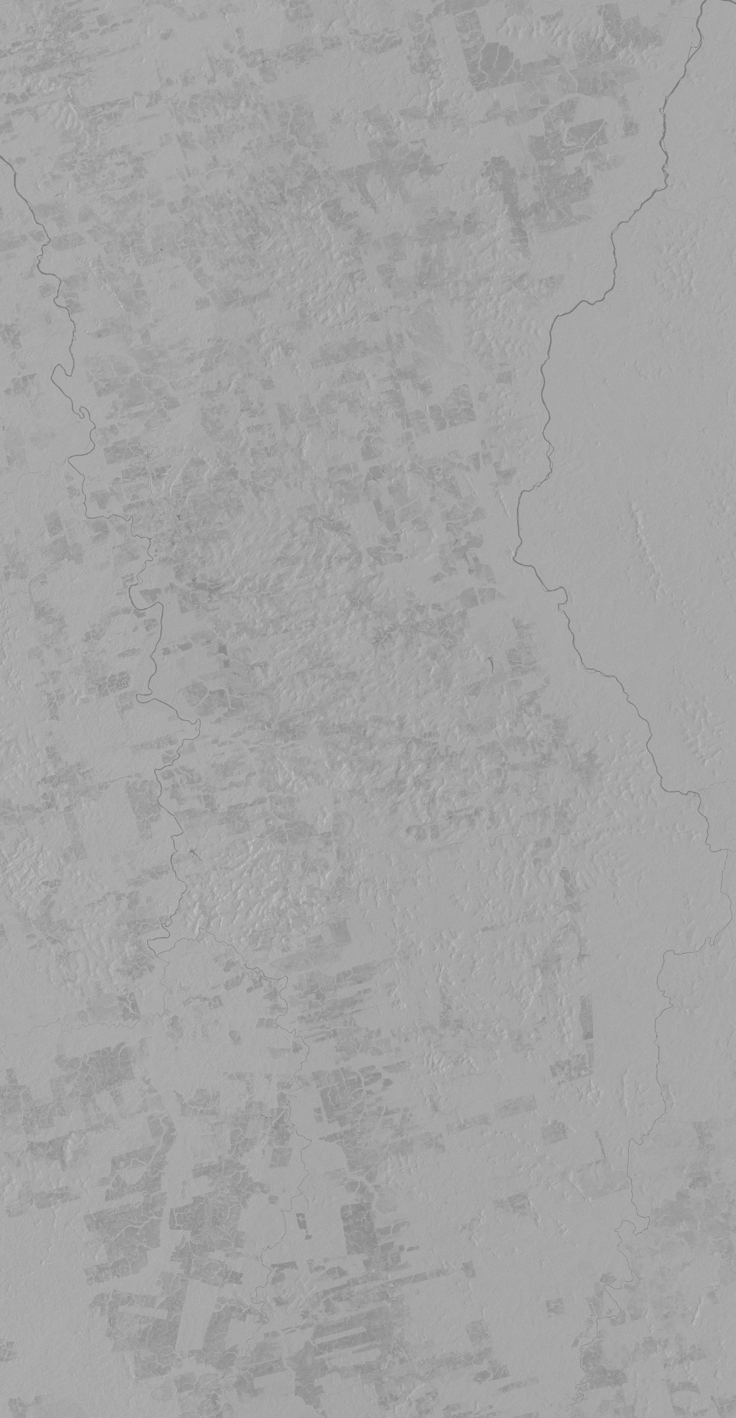

In [55]:
img = Image.fromarray(np.uint8(sar[:, :, 0]*255))
resize = 0.08
shape = (int(resize*sar.shape[1]), int(resize*sar.shape[0]))
img.resize(shape)

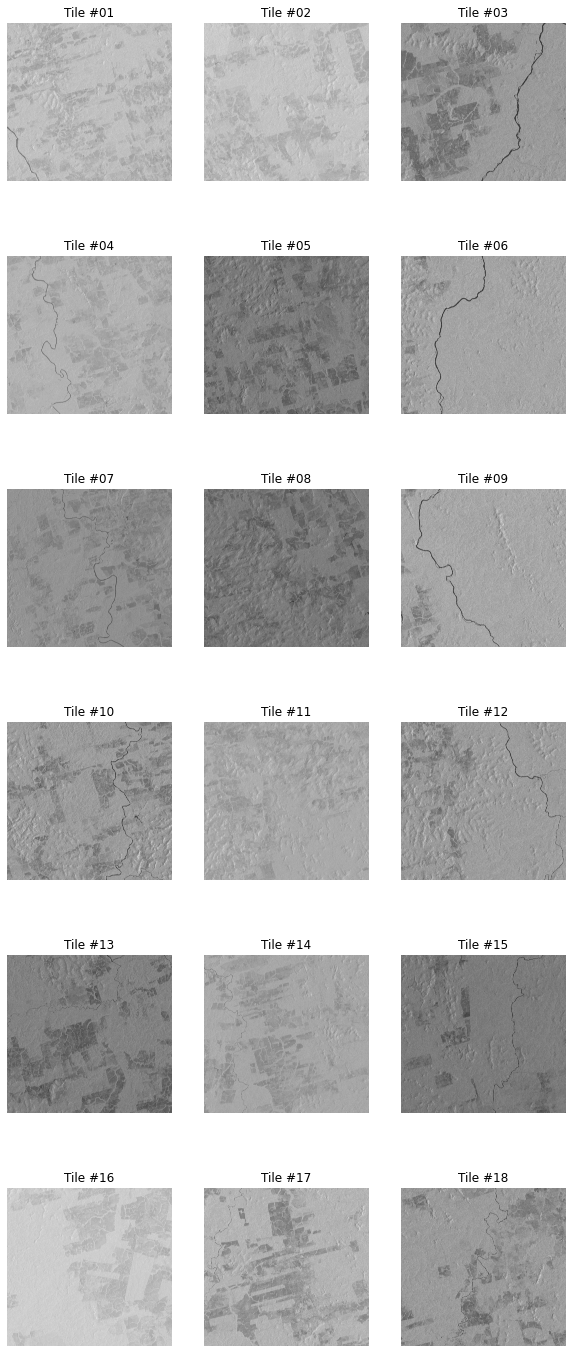

In [57]:
fig, ax = plt.subplots(nrows=params_patches['tiles_v'], ncols=params_patches['tiles_h'], figsize = (10,25))

for row_idx, row in enumerate(ax):
    for col_idx, col in enumerate(row):
        tile_idx = row_idx*params_patches['tiles_h'] + col_idx
        categorical = tiles[tile_idx][:, :, 0]
        img = Image.fromarray(np.uint8(categorical*255))
        col.axis('off')
        col.set_title(f'Tile #{tile_idx+1:02d}')
        col.imshow(img, cmap = 'gray')